versions of module used for development:
Python version: 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]
numpy version: 1.26.3
pandas version: 2.1.1
sklearn version: 1.3.2
statsmodels version: 0.14.0
colorama version: 0.4.4
matplotlib version: 3.8.0
re version: 2.2.1
pickle version: 4.0

!pip install numpy==1.26.3 pandas==2.1.1 scikit-learn==1.3.2 statsmodels==0.14.0 colorama==0.4.4 matplotlib==3.8.0 pickle==4.0

In [1]:
import numpy as np
import pandas as pd
import warnings
import os, re, math, time
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from colorama import Fore
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pickle

import sklearn
import statsmodels
import colorama
import matplotlib
import sys

warnings.filterwarnings("ignore")

In [2]:
# import file with all input data

df=pd.read_parquet('s3://576118004139-ap-south-1-kbl-datamart-l2/datamartl2/behavioural_model_v2/final_dataset/v12/')
df=df[df['goldl_present'].notnull()]
df.replace([np.inf, -np.inf], np.nan, inplace=True)

df['mab_1m_12m']=df['mab_1m_12m'].fillna(0)
# df=df.drop('active_loans')
df_dev=df[df['dev']=='1']
df_oot=df[df['dev']=='0']


print(df.shape)

print(df_dev.shape)

print(df_oot.shape)

(312275, 403)
(143809, 403)
(168466, 403)


In [3]:
df_dev['bad'].value_counts()

bad
0    138735
1      5074
Name: count, dtype: int64

In [4]:
df_oot['bad'].value_counts()

bad
0    163850
1      4616
Name: count, dtype: int64

In [5]:
df_dev.shape

(143809, 403)

In [6]:
df_dev['snap_dt'].value_counts()

snap_dt
2023-03-31    73014
2023-01-31    70795
Name: count, dtype: int64

In [7]:
# df_dev['num_loans_gt90del_l24m'].value_counts()

In [8]:
df['retail_flag']

0         1
1         0
2         0
4         1
5         0
         ..
371501    1
371502    1
371503    1
371504    1
371505    1
Name: retail_flag, Length: 312275, dtype: int32

In [9]:
df_oot['snap_dt'].value_counts()

snap_dt
2023-11-30    84843
2023-10-31    83623
Name: count, dtype: int64

In [10]:
df_dev[['loans_30dpd_l12m']].value_counts()

loans_30dpd_l12m
0.0                 44517
1.0                 18753
2.0                  2505
3.0                   545
4.0                   177
5.0                    95
7.0                    26
6.0                    24
8.0                     5
9.0                     4
11.0                    3
12.0                    2
13.0                    2
10.0                    1
Name: count, dtype: int64

In [11]:
# # 's3://576118004139-ap-south-1-kbl-datamart-l2/datamartl2/behavioural_model_v2/final_dataset/v6/'
# df1=pd.read_parquet('s3://576118004139-ap-south-1-kbl-datamart-l2/datamartl2/behavioural_model_v2/final_dataset/v6/')
# df1.replace([np.inf, -np.inf], np.nan, inplace=True)
# # df['mab_1m_12m']=df['mab_1m_12m'].fillna(0)

# df_dev1=df1[df1['dev']=='1']
# df_oot1=df1[df1['dev']=='0']


# print(df1.shape)

# print(df_dev1.shape)

# print(df_oot1.shape)


In [12]:
pd.DataFrame(df.columns).to_csv('all_cols_pk.csv')

In [13]:
# df1[['snap_dt','dev']].value_counts()

In [14]:
df_dev.head()

cust_id     snap_dt  bad dev  l24m90plus  l24m60plus  l24m30plus  \
0   R01118367  2023-03-31    0   1         0.0         0.0         0.0   
7   029107904  2023-01-31    0   1         0.0         1.0         1.0   
10  R01412339  2023-03-31    0   1         0.0         0.0         0.0   
14  351109104  2023-03-31    0   1         0.0         0.0         0.0   
15  310118742  2023-01-31    0   1         0.0         0.0         0.0   

    l12m90plus  l12m60plus  l12m30plus  ...  c2d_amt_6m  c2d_cnt_6m  \
0          0.0         0.0         0.0  ...      0.9995         0.0   
7          0.0         1.0         1.0  ...        None         NaN   
10         0.0         0.0         0.0  ...      0.6715         0.0   
14         0.0         0.0         0.0  ...      0.8699         1.0   
15         0.0         0.0         0.0  ...      1.0125         0.0   

    c2d_amt_12m  c2d_cnt_12m         exposure  retail_flag  msme_loan  \
0        0.9986          0.0  578462.00000000            1          0   
7          None          NaN  565375.42000000            1          0   
10       0.9993          0.0  549669.00000000            1          0   
14       0.8637          0.0  192331.77000000            1          0   
15       0.8480          0.0  248865.00000000            1          0   

    no_months_no_del_l12m  bad_early  inward_chq_bounce_ever  
0                      12          0                       1  
7                       1          0                       0  
10                     12          0                       0  
14                     12          0                       1  
15                     12          0                       0  

[5 rows x 403 columns]

In [15]:
df_oot.head()

cust_id     snap_dt  bad dev  l24m90plus  l24m60plus  l24m30plus  \
1  076120993  2023-11-30    0   0         1.0         1.0         1.0   
2  182062248  2023-11-30    0   0         1.0         1.0         1.0   
4  705074916  2023-10-31    0   0         1.0         1.0         1.0   
5  005012992  2023-11-30    0   0         0.0         0.0         0.0   
8  426110767  2023-11-30    0   0         0.0         1.0         1.0   

   l12m90plus  l12m60plus  l12m30plus  ...  c2d_amt_6m  c2d_cnt_6m  \
1         1.0         1.0         1.0  ...        None         NaN   
2         1.0         1.0         1.0  ...        None         NaN   
4         1.0         1.0         1.0  ...      0.5042         1.0   
5         0.0         0.0         0.0  ...      0.9923         0.0   
8         0.0         1.0         1.0  ...        None         NaN   

   c2d_amt_12m  c2d_cnt_12m          exposure  retail_flag  msme_loan  \
1         None          NaN              None            0          1   
2         None          NaN              None            0          1   
4       0.7173          1.0  2822383.00000000            1          0   
5       1.0132          0.0   162692.00000000            0          1   
8         None          NaN   253959.63000000            1          0   

   no_months_no_del_l12m  bad_early  inward_chq_bounce_ever  
1                      0          0                       0  
2                      0          0                       0  
4                      0          1                       1  
5                     11          0                       0  
8                      2          0                       0  

[5 rows x 403 columns]

In [16]:
df_dev.shape

(143809, 403)

In [17]:
df_oot.shape

(168466, 403)

In [18]:
#pd.DataFrame(df_dev.dtypes).to_csv('data_types_PK.csv')

In [19]:
# data type conversions

dtype_dict={
'cust_id' : 'str',
'snap_dt' : 'str',
'bad' : 'int32',
'dev' : 'int32',
'l24m90plus' : 'float64',
'l24m60plus' : 'float64',
'l24m30plus' : 'float64',
'l12m90plus' : 'float64',
'l12m60plus' : 'float64',
'l12m30plus' : 'float64',
'l6m90plus' : 'float64',
'l6m60plus' : 'float64',
'l6m30plus' : 'float64',
'cc_bal_l6m' : 'float64',
'cc_bal_l12m' : 'float64',
'cc_bal_l18m' : 'float64',
'cc_bal_l24m' : 'float64',
'cc_limit_max_l6m' : 'float64',
'cc_limit_max_l12m' : 'float64',
'cc_limit_max_l18m' : 'float64',
'cc_limit_max_l24m' : 'float64',
'month_since_last90plus_l24m' : 'float64',
'month_since_last60plus_l24m' : 'float64',
'month_since_last30plus_l24m' : 'float64',
'highest_dpd_l6m' : 'float64',
'highest_dpd_l12m' : 'float64',
'highest_dpd_l18m' : 'float64',
'highest_dpd_l24m' : 'float64',
'l12_written_off' : 'float64',
'l24m_written_off' : 'float64',
'cc_util_6m_avg' : 'float64',
'cc_util_12m_avg' : 'float64',
'cc_util_18m_avg' : 'float64',
'cc_util_24m_avg' : 'float64',
'cc_present_ever' : 'float64',
'bl_present_ever' : 'float64',
'pl_present_ever' : 'float64',
'hl_present_ever' : 'float64',
'al_present_ever' : 'float64',
'mfi_present_ever' : 'float64',
'consumer_loan_present_ever' : 'float64',
'od_present_ever' : 'float64',
'securedl_present_ever' : 'float64',
'goldl_present_ever' : 'float64',
'groupl_present_ever' : 'float64',
'professional_loan_present_ever' : 'float64',
'cc_present' : 'float64',
'bl_present' : 'float64',
'pl_present' : 'float64',
'hl_present' : 'float64',
'al_present' : 'float64',
'mfi_present' : 'float64',
'consumer_loan_present' : 'float64',
'od_present' : 'float64',
'securedl_present' : 'float64',
'goldl_present' : 'float64',
'groupl_present' : 'float64',
'professional_loan_present' : 'float64',
'cc_opnd_l6m' : 'float64',
'cc_opnd_l12m' : 'float64',
'cc_opnd_l18m' : 'float64',
'cc_opnd_l24m' : 'float64',
'pl_opnd_l6m' : 'float64',
'pl_opnd_l12m' : 'float64',
'pl_opnd_l18m' : 'float64',
'pl_opnd_l24m' : 'float64',
'al_opnd_l6m' : 'float64',
'al_opnd_l12m' : 'float64',
'al_opnd_l18m' : 'float64',
'al_opnd_l24m' : 'float64',
'mfi_opnd_l6m' : 'float64',
'mfi_opnd_l12m' : 'float64',
'mfi_opnd_l18m' : 'float64',
'mfi_opnd_l24m' : 'float64',
'consumer_loan_opnd_l6m' : 'float64',
'consumer_loan_opnd_l12m' : 'float64',
'consumer_loan_opnd_l18m' : 'float64',
'consumer_loan_opnd_l24m' : 'float64',
'gold_loan_opnd_l6m' : 'float64',
'gold_loan_opnd_l12m' : 'float64',
'gold_loan_opnd_l18m' : 'float64',
'gold_loan_opnd_l24m' : 'float64',
'od_opnd_l6m' : 'float64',
'od_opnd_l12m' : 'float64',
'od_opnd_l18m' : 'float64',
'od_opnd_l24m' : 'float64',
'bureau_score_latest' : 'float64',
'bureau_score_band' : 'str',
'no_inq_l6m' : 'float64',
'no_inq_cc_l6m' : 'float64',
'no_inq_pl_l6m' : 'float64',
'no_inq_unsecured_l6m' : 'float64',
'no_inq_secured_l6m' : 'float64',
'no_inq_l12m' : 'float64',
'no_inq_cc_l12m' : 'float64',
'no_inq_pl_l12m' : 'float64',
'no_inq_unsecured_l12m' : 'float64',
'no_inq_secured_l12m' : 'float64',
'no_inq_l18m' : 'float64',
'no_inq_cc_l18m' : 'float64',
'no_inq_pl_l18m' : 'float64',
'no_inq_unsecured_l18m' : 'float64',
'no_inq_secured_l18m' : 'float64',
'no_inq_l24m' : 'float64',
'no_inq_cc_l24m' : 'float64',
'no_inq_pl_l24m' : 'float64',
'no_inq_unsecured_l24m' : 'float64',
'no_inq_secured_l24m' : 'float64',
'month_since_pl_inq_l24m' : 'float64',
'month_since_cc_inq_l24m' : 'float64',
'month_since_gl_inq_l24m' : 'float64',
'month_since_last_loan_inq_l24m' : 'float64',
'month_since_unsecured_inq' : 'float64',
'month_since_secured_inq' : 'float64',
'bureau_credit_age' : 'float64',
'age_newest_trade' : 'float64',
'age_oldest_active_trd' : 'float64',
'age_newest_active_trd' : 'float64',
'num_loans_closed_max_0dpd' : 'float64',
'num_loans_closed_max_10dpd' : 'float64',
'num_loans_closed_max_20dpd' : 'float64',
'num_loans_closed_max_30dpd' : 'float64',
'tot_clsd_trades' : 'float64',
'trade_clsd_l6m' : 'float64',
'trade_clsd_l12m' : 'float64',
'trade_clsd_l18m' : 'float64',
'trade_clsd_l24m' : 'float64',
'tot_opn_trades' : 'float64',
'trade_opn_l6m' : 'float64',
'trade_opn_l12m' : 'float64',
'trade_opn_l18m' : 'float64',
'trade_opn_l24m' : 'float64',
'tot_unsec_trades_open' : 'float64',
'tot_unsec_trades_open_l6m' : 'float64',
'tot_unsec_trades_open_l12m' : 'float64',
'tot_unsec_trades_open_l18m' : 'float64',
'tot_unsec_trades_open_l24m' : 'float64',
'tot_sec_trades_open' : 'float64',
'tot_sec_trades_open_l6m' : 'float64',
'tot_sec_trades_open_l12m' : 'float64',
'tot_sec_trades_open_l18m' : 'float64',
'tot_sec_trades_open_l24m' : 'float64',
'ratio_trd_clsd_l6m_tot_clsd' : 'float64',
'ratio_trd_clsd_l12m_tot_clsd' : 'float64',
'ratio_trd_clsd_l18m_tot_clsd' : 'float64',
'ratio_trd_clsd_l24m_tot_clsd' : 'float64',
'ratio_trd_opn_l6m_tot_opn' : 'float64',
'ratio_trd_opn_l12m_tot_opn' : 'float64',
'ratio_trd_opn_l18m_tot_opn' : 'float64',
'ratio_trd_opn_l24m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_tot' : 'float64',
'ratio_unsec_trd_opn_l6m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_l12m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_l18m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_l24m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_l6m_tot_l6m_opn' : 'float64',
'ratio_unsec_trd_opn_l12m_tot_l12m_opn' : 'float64',
'ratio_unsec_trd_opn_l18m_tot_l18m_opn' : 'float64',
'ratio_unsec_trd_opn_l24m_tot_l24m_opn' : 'float64',
'ratio_sec_trd_opn_tot' : 'float64',
'ratio_sec_trd_opn_l6m_tot_opn' : 'float64',
'ratio_sec_trd_opn_l12m_tot_opn' : 'float64',
'ratio_sec_trd_opn_l18m_tot_opn' : 'float64',
'ratio_sec_trd_opn_l24m_tot_opn' : 'float64',
'ratio_sec_trd_opn_l6m_tot_l6m_opn' : 'float64',
'ratio_sec_trd_opn_l12m_tot_l12m_opn' : 'float64',
'ratio_sec_trd_opn_l18m_tot_l18m_opn' : 'float64',
'ratio_sec_trd_opn_l24m_tot_l24m_opn' : 'float64',
'ratio_trd_clsd_opn_l6m' : 'float64',
'ratio_trd_clsd_opn_l12m' : 'float64',
'ratio_trd_clsd_opn_l18m' : 'float64',
'ratio_trd_clsd_opn_l24m' : 'float64',
'max_sanc_amt_unsecured_l24m' : 'float64',
'max_sanc_amt_unsecured_l18m' : 'float64',
'max_sanc_amt_unsecured_l12m' : 'float64',
'max_sanc_amt_unsecured_l6m' : 'float64',
'max_sanc_amt_secured_l24m' : 'float64',
'max_sanc_amt_secured_l18m' : 'float64',
'max_sanc_amt_secured_l12m' : 'float64',
'max_sanc_amt_secured_l6m' : 'float64',
'percent_del_amt_l12m' : 'float64',
'ratio_trade_amt_opnd_clsed_l6m' : 'float64',
'ratio_trade_amt_opnd_clsed_l12m' : 'float64',
'ratio_trade_amt_opnd_clsed_l24m' : 'float64',
'num_loans_lt30del_l24m' : 'float64',
'num_loans_lt30del_l18m' : 'float64',
'num_loans_lt30del_l12m' : 'float64',
'num_loans_lt30del_l6m' : 'float64',
'num_loans_gt30del_l24m' : 'float64',
'num_loans_gt30del_l18m' : 'float64',
'num_loans_gt30del_l12m' : 'float64',
'num_loans_gt30del_l6m' : 'float64',
'num_loans_gt60del_l24m' : 'float64',
'num_loans_gt60del_l18m' : 'float64',
'num_loans_gt60del_l12m' : 'float64',
'num_loans_gt60del_l6m' : 'float64',
'num_loans_gt90del_l24m' : 'float64',
'num_loans_gt90del_l18m' : 'float64',
'num_loans_gt90del_l12m' : 'float64',
'num_loans_gt90del_l6m' : 'float64',
'overdue_amt_l6m' : 'float64',
'overdue_amt_l12m' : 'float64',
'overdue_amt_l18m' : 'float64',
'overdue_amt_l24m' : 'float64',
'avg_loan_cnt_gt10k_l2yrs' : 'float64',
'avg_loan_cnt_ge50k_l2yrs' : 'float64',
'cnt_loan_cnt_ge50k_l1yrs' : 'float64',
'cnt_loan_cnt_ge50k_l18m' : 'float64',
'cnt_loan_cnt_gt10k_l6m' : 'float64',
'median_loan_amount_l6m' : 'float64',
'median_loan_amount_l12m' : 'float64',
'median_loan_amount_l18m' : 'float64',
'median_loan_amount_l24m' : 'float64',
'month_since_first_loan_ge50k' : 'float64',
'exposure_increase_bureau_l6m_l12m' : 'float64',
'latest_tot_bal_unsecured' : 'float64',
'latest_tot_bal_secured' : 'float64',
'latest_tot_bal_all_prd' : 'float64',
'loan_outstanding_bal_l6m_l12m' : 'float64',
'loan_outstanding_bal_l12m_l24m' : 'float64',
'no_months_max_dpd10_l12m' : 'float64',
'no_months_max_dpd7_l12m' : 'float64',
'no_months_max_dpd5_l12m' : 'float64',
'no_months_max_dpd3_l12m' : 'float64',
'l3m30recovery' : 'float64',
'l3m60recovery' : 'float64',
'l6m30recovery' : 'float64',
'l6m60recovery' : 'float64',
'l9m30recovery' : 'float64',
'l9m60recovery' : 'float64',
'l12m30recovery' : 'float64',
'l12m60recovery' : 'float64',
'l3m30forward' : 'float64',
'l3m60forward' : 'float64',
'l6m30forward' : 'float64',
'l6m60forward' : 'float64',
'l9m30forward' : 'float64',
'l9m60forward' : 'float64',
'l12m30forward' : 'float64',
'l12m60forward' : 'float64',
'cntl6m0plus' : 'float64',
'cntl12m0plus' : 'float64',
'cntl6m30plus' : 'float64',
'cntl12m30plus' : 'float64',
'cntl6m60plus' : 'float64',
'cntl12m60plus' : 'float64',
'cntl6m90plus' : 'float64',
'cntl12m90plus' : 'float64',
'ratio0plusinl6mto12m' : 'float64',
'ratio30plusinl6mto12m' : 'float64',
'ratio60plusinl6mto12m' : 'float64',
'ratio90plusinl6mto12m' : 'float64',
'active_loans' : 'float64',
'active_loans_outstanding' : 'float64',
'active_loans_sanctions' : 'float64',
'active_oda_outstanding' : 'float64',
'active_oda_sanctions' : 'float64',
'avg_mab_12m' : 'float64',
'avg_mab_1m' : 'float64',
'avg_mab_3m' : 'float64',
'avg_mab_6m' : 'float64',
'avg_td_12m' : 'float64',
'avg_td_1m' : 'float64',
'avg_td_3m' : 'float64',
'avg_td_6m' : 'float64',
'cnt_12m_loan_closed' : 'float64',
'cnt_12m_loan_opened' : 'float64',
'cnt_3m_loan_closed' : 'float64',
'cnt_3m_loan_opened' : 'float64',
'cnt_6m_loan_closed' : 'float64',
'cnt_6m_loan_opened' : 'float64',
'cnt_loan_opened' : 'float64',
'cust_marital_status' : 'str',
'customer_age' : 'float64',
'customer_vintage' : 'float64',
'days_in_stress_l12m' : 'float64',
'days_in_stress_l3m' : 'float64',
'days_in_stress_l6m' : 'float64',
'inward_chq_bounce_l12m_flag' : 'float64',
'inward_chq_bounce_l24m_flag' : 'float64',
'inward_chq_bounce_l3m_flag' : 'float64',
'inward_chq_bounce_l6m_flag' : 'float64',
'l12m_deposit_amt' : 'float64',
'l12m_deposit_cnt' : 'float64',
'l12m_dpd_month_cnt' : 'float64',
'l3m_deposit_amt' : 'float64',
'l3m_deposit_cnt' : 'float64',
'l3m_dpd_month_cnt' : 'float64',
'l6m_deposit_amt' : 'float64',
'l6m_deposit_cnt' : 'float64',
'l6m_dpd_month_cnt' : 'float64',
'loan_age' : 'float64',
'loans_30dpd_l12m' : 'float64',
'loans_30dpd_l3m' : 'float64',
'loans_30dpd_l6m' : 'float64',
'loans_3dpd_l12m' : 'float64',
'loans_3dpd_l3m' : 'float64',
'loans_3dpd_l6m' : 'float64',
'loans_5_or_7_dpd_l12m' : 'float64',
'mab_12m' : 'float64',
'mab_1m' : 'float64',
'mab_1m_12m' : 'float64',
'mab_3m' : 'float64',
'mab_3m_12m' : 'float64',
'mab_6m' : 'float64',
'mab_6m_12m' : 'float64',
'max_dpd_l12m' : 'float64',
'max_dpd_l3m' : 'float64',
'max_dpd_l6m' : 'float64',
'outward_chq_bounce_l12m_flag' : 'float64',
'outward_chq_bounce_l24m_flag' : 'float64',
'outward_chq_bounce_l3m_flag' : 'float64',
'outward_chq_bounce_l6m_flag' : 'float64',
'c_amt_3m' : 'float64',
'd_amt_3m' : 'float64',
'c_cnt_3m' : 'float64',
'd_cnt_3m' : 'float64',
'c_amt_6m' : 'float64',
'd_amt_6m' : 'float64',
'c_cnt_6m' : 'float64',
'd_cnt_6m' : 'float64',
'c_amt_12m' : 'float64',
'd_amt_12m' : 'float64',
'c_cnt_12m' : 'float64',
'd_cnt_12m' : 'float64',
'c_cnt_3m_30k_50k' : 'float64',
'c_cnt_3m_50k_75k' : 'float64',
'c_cnt_3m_75k_1l' : 'float64',
'c_cnt_3m_1l_and_above' : 'float64',
'd_cnt_3m_30k_50k' : 'float64',
'd_cnt_3m_50k_75k' : 'float64',
'd_cnt_3m_75k_1l' : 'float64',
'd_cnt_3m_1l_and_above' : 'float64',
'c_cnt_6m_ge_30k' : 'float64',
'c_cnt_6m_ge_50k' : 'float64',
# 'c_cnt_6m_75k_1l' : 'float64',
# 'c_cnt_6m_1l_and_above' : 'float64',
'd_cnt_6m_30k_50k' : 'float64',
'd_cnt_6m_50k_75k' : 'float64',
'd_cnt_6m_75k_1l' : 'float64',
'd_cnt_6m_1l_and_above' : 'float64',
'c_cnt_12m_30k_50k' : 'float64',
'c_cnt_12m_50k_75k' : 'float64',
'c_cnt_12m_75k_1l' : 'float64',
'c_cnt_12m_1l_and_above' : 'float64',
'd_cnt_12m_30k_50k' : 'float64',
'd_cnt_12m_50k_75k' : 'float64',
'd_cnt_12m_75k_1l' : 'float64',
'd_cnt_12m_1l_and_above' : 'float64',
'm1_atm_credit_amt' : 'float64',
'm1_upi_credit_amt' : 'float64',
'm1_neft_credit_amt' : 'float64',
'm1_rtgs_credit_amt' : 'float64',
'm1_imps_credit_amt' : 'float64',
'm1_cash_chq_amt' : 'float64',
'm3_atm_credit_amt' : 'float64',
'm3_upi_credit_amt' : 'float64',
'm3_neft_credit_amt' : 'float64',
'm3_rtgs_credit_amt' : 'float64',
'm3_imps_credit_amt' : 'float64',
'm3_cash_chq_amt' : 'float64',
'm6_atm_credit_amt' : 'float64',
'm6_upi_credit_amt' : 'float64',
'm6_neft_credit_amt' : 'float64',
'm6_rtgs_credit_amt' : 'float64',
'm6_imps_credit_amt' : 'float64',
'm6_cash_chq_amt' : 'float64',
'm12_atm_credit_amt' : 'float64',
'm12_upi_credit_amt' : 'float64',
'm12_neft_credit_amt' : 'float64',
'm12_rtgs_credit_amt' : 'float64',
'm12_imps_credit_amt' : 'float64',
'm12_cash_chq_amt' : 'float64',
'm1_atm_debit_amt' : 'float64',
'm1_upi_debit_amt' : 'float64',
'm1_neft_debit_amt' : 'float64',
'm1_rtgs_debit_amt' : 'float64',
'm1_imps_debit_amt' : 'float64',
'm3_atm_debit_amt' : 'float64',
'm3_upi_debit_amt' : 'float64',
'm3_neft_debit_amt' : 'float64',
'm3_rtgs_debit_amt' : 'float64',
'm3_imps_debit_amt' : 'float64',
'm6_atm_debit_amt' : 'float64',
'm6_upi_debit_amt' : 'float64',
'm6_neft_debit_amt' : 'float64',
'm6_rtgs_debit_amt' : 'float64',
'm6_imps_debit_amt' : 'float64',
'm12_atm_debit_amt' : 'float64',
'm12_upi_debit_amt' : 'float64',
'm12_neft_debit_amt' : 'float64',
'm12_rtgs_debit_amt' : 'float64',
'm12_imps_debit_amt' : 'float64',
'c2d_amt_3m' : 'float64',
'c2d_cnt_3m' : 'float64',
'c2d_amt_6m' : 'float64',
'c2d_cnt_6m' : 'float64',
'c2d_amt_12m' : 'float64',
'c2d_cnt_12m' : 'float64',
'bad_early' : 'float64'
}
df_dev = df_dev.astype(dtype_dict)
df_oot = df_oot.astype(dtype_dict)

In [20]:
# missing values count

try:
    100*(df_dev.isnull().sum()/len(df_dev)).to_csv('missing_counts_PK.csv')
except:
    print('continue')

continue


In [21]:
# to check monotonicity of a series, woe and iv

def is_monotonic(temp_series):
    return all(temp_series[i] <= temp_series[i + 1] for i in range(len(temp_series) - 1)) or all(temp_series[i] >= temp_series[i + 1] for i in range(len(temp_series) - 1))

def prepare_bins(bin_data, c_i, target_col, max_bins):
    force_bin = True
    binned = False
    remarks = np.nan
    # ----------------- Monotonic binning -----------------
    for n_bins in range(max_bins, 5, -1):
        try:
            bin_data[c_i + "_bins"] = pd.qcut(bin_data[c_i], n_bins, duplicates="drop")
            monotonic_series = bin_data.groupby(c_i + "_bins")[target_col].mean().reset_index(drop=True)
            if is_monotonic(monotonic_series):
                force_bin = False
                binned = True
                remarks = "binned monotonically"
                break
        except:
            pass
    # ----------------- Force binning -----------------
    # creating 2 bins forcefully because 2 bins will always be monotonic
    if force_bin or (c_i + "_bins" in bin_data and bin_data[c_i + "_bins"].nunique() < 2):
        _min=bin_data[c_i].min()
        _mean=bin_data[c_i].mean()
        _max=bin_data[c_i].max()
        # print(c_i)
        bin_data[c_i + "_bins"] = pd.cut(bin_data[c_i], [_min, _mean, _max], include_lowest=True)
        if bin_data[c_i + "_bins"].nunique() == 2:
            binned = True
            remarks = "binned forcefully"
    
    if binned:
        return c_i + "_bins", remarks, bin_data[[c_i, c_i+"_bins", target_col]].copy()
    else:
        remarks = "couldn't bin"
        return c_i, remarks, bin_data[[c_i, target_col]].copy()

# calculate WOE and IV for every group/bin/class for a provided feature
def iv_woe_4iter(binned_data, target_col, class_col):
    if "_bins" in class_col:
        binned_data[class_col] = binned_data[class_col].cat.add_categories(['Missing'])
        binned_data[class_col] = binned_data[class_col].fillna("Missing")
        temp_groupby = binned_data.groupby(class_col).agg({class_col.replace("_bins", ""):["min", "max"],
                                                           target_col: ["count", "sum", "mean"]}).reset_index()
    else:
        binned_data[class_col] = binned_data[class_col].fillna("Missing")
        temp_groupby = binned_data.groupby(class_col).agg({class_col:["first", "first"],
                                                           target_col: ["count", "sum", "mean"]}).reset_index()
    
    temp_groupby.columns = ["sample_class", "min_value", "max_value", "sample_count", "event_count", "event_rate"]
    temp_groupby["non_event_count"] = temp_groupby["sample_count"] - temp_groupby["event_count"]
    temp_groupby["non_event_rate"] = 1 - temp_groupby["event_rate"]
    temp_groupby = temp_groupby[["sample_class", "min_value", "max_value", "sample_count",
                                 "non_event_count", "non_event_rate", "event_count", "event_rate"]]
    
    if "_bins" not in class_col and "Missing" in temp_groupby["min_value"]:
        temp_groupby["min_value"] = temp_groupby["min_value"].replace({"Missing": np.nan})
        temp_groupby["max_value"] = temp_groupby["max_value"].replace({"Missing": np.nan})
    temp_groupby["feature"] = class_col
    if "_bins" in class_col:
        temp_groupby["sample_class_label"]=temp_groupby["sample_class"].replace({"Missing": np.nan}).astype('category').cat.codes.replace({-1: np.nan})
    else:
        temp_groupby["sample_class_label"]=np.nan
    temp_groupby = temp_groupby[["feature", "sample_class", "sample_class_label", "sample_count", "min_value", "max_value",
                                 "non_event_count", "non_event_rate", "event_count", "event_rate"]]
    
    """
    **********get distribution of good and bad
    """
    temp_groupby['distbn_non_event'] = temp_groupby["non_event_count"]/temp_groupby["non_event_count"].sum()
    temp_groupby['distbn_event'] = temp_groupby["event_count"]/temp_groupby["event_count"].sum()

    temp_groupby['woe'] = np.log(temp_groupby['distbn_non_event'] / temp_groupby['distbn_event'])
    temp_groupby['iv'] = (temp_groupby['distbn_non_event'] - temp_groupby['distbn_event']) * temp_groupby['woe']
    
    temp_groupby["woe"] = temp_groupby["woe"].replace([np.inf,-np.inf],0)
    temp_groupby["iv"] = temp_groupby["iv"].replace([np.inf,-np.inf],0)
    
    return temp_groupby

"""
- iterate over all features.
- calculate WOE & IV for there classes.
- append to one DataFrame woe_iv.
"""
def var_iter(data, target_col, max_bins):
    woe_iv = pd.DataFrame()
    remarks_list = []
    for c_i in data.columns:
        if c_i not in [target_col]:
            # check if binning is required. if yes, then prepare bins and calculate woe and iv.
            """
            ----logic---
            binning is done only when feature is continuous and non-binary.
            Note: Make sure dtype of continuous columns in dataframe is not object.
            """
            c_i_start_time=time.time()
            if np.issubdtype(data[c_i], np.number) and data[c_i].nunique() > 2:
                class_col, remarks, binned_data = prepare_bins(data[[c_i, target_col]].copy(), c_i, target_col, max_bins)
                agg_data = iv_woe_4iter(binned_data.copy(), target_col, class_col)
                remarks_list.append({"feature": c_i, "remarks": remarks})
                # remarks_list = pd.concat([remarks_list, {"feature": c_i, "remarks": remarks}])
            else:
                agg_data = iv_woe_4iter(data[[c_i, target_col]].copy(), target_col, c_i)
                # remarks_list = pd.concat([remarks_list, {"feature": c_i, "remarks": "categorical"}])
                remarks_list.append({"feature": c_i, "remarks": "categorical"})
            # print("---{} seconds. c_i: {}----".format(round(time.time() - c_i_start_time, 2), c_i))
            woe_iv = pd.concat([woe_iv, agg_data])
            # woe_iv = woe_iv.append(agg_data)
    return woe_iv, pd.DataFrame(remarks_list)

# after getting woe and iv for all classes of features calculate aggregated IV values for features.
def get_iv_woe(data, target_col, max_bins):
    func_start_time = time.time()
    woe_iv, binning_remarks = var_iter(data, target_col, max_bins)
    print("------------------IV and WOE calculated for individual groups.------------------")
    print("Total time elapsed: {} minutes".format(round((time.time() - func_start_time) / 60, 3)))
    
    woe_iv["feature"] = woe_iv["feature"].replace("_bins", "", regex=True)    
    woe_iv = woe_iv[["feature", "sample_class", "sample_class_label", "sample_count", "min_value", "max_value",
                     "non_event_count", "non_event_rate", "event_count", "event_rate", 'distbn_non_event',
                     'distbn_event', 'woe', 'iv']]
    
    iv = woe_iv.groupby("feature")[["iv"]].agg(["sum", "count"]).reset_index()
    print("------------------Aggregated IV values for features calculated.------------------")
    print("Total time elapsed: {} minutes".format(round((time.time() - func_start_time) / 60, 3)))
    
    iv.columns = ["feature", "iv", "number_of_classes"]
    null_percent_data=pd.DataFrame(data.isnull().mean()).reset_index()
    null_percent_data.columns=["feature", "feature_null_percent"]
    iv=iv.merge(null_percent_data, on="feature", how="left")
    print("------------------Null percent calculated in features.------------------")
    print("Total time elapsed: {} minutes".format(round((time.time() - func_start_time) / 60, 3)))
    iv = iv.merge(binning_remarks, on="feature", how="left")
    woe_iv = woe_iv.merge(iv[["feature", "iv", "remarks"]].rename(columns={"iv": "iv_sum"}), on="feature", how="left")
    print("------------------Binning remarks added and process is complete.------------------")
    print("Total time elapsed: {} minutes".format(round((time.time() - func_start_time) / 60, 3)))
    return iv, woe_iv.replace({"Missing": np.nan})

In [22]:
# get iv and woe values fromm above function

IV,final_iv = get_iv_woe(df_dev.loc[:, ~df_dev.columns.isin(['cust_id','snap_dt','dev'])], target_col="bad", max_bins=8)

------------------IV and WOE calculated for individual groups.------------------
Total time elapsed: 0.279 minutes
------------------Aggregated IV values for features calculated.------------------
Total time elapsed: 0.28 minutes
------------------Null percent calculated in features.------------------
Total time elapsed: 0.284 minutes
------------------Binning remarks added and process is complete.------------------
Total time elapsed: 0.285 minutes


In [23]:
# saving woe and iv to file

final_iv.to_csv("woe_iv_BM.csv")
IV.to_csv("iv_BM.csv")

In [24]:
# save flooring, capping 
import pickle
numeric_cols = df_dev.select_dtypes(include=np.number).columns.to_list()
cols_bool=[col for col in df_dev.columns if df_dev[col].isin([0, 1]).all()]   

percentiles_dict={}

for col in numeric_cols:
    if col not in cols_bool:
        percentiles = df_dev[col].quantile([0.01, 0.99]).values
        # print(percentiles)
        percentiles_dict[col] = (percentiles[0], percentiles[1])
        df_dev[col][df_dev[col] <= percentiles[0]] = percentiles[0]
        df_dev[col][df_dev[col] >= percentiles[1]] = percentiles[1]
        
# print(percentiles_dict)
print('capping flooring done')
with open('percentiles_dict_bm.pkl', 'wb') as file:
    pickle.dump(percentiles_dict, file)
    
with open('cols_bool_bm.pkl', 'wb') as f:
    pickle.dump(cols_bool, f)

with open('numeric_cols_bm.pkl', 'wb') as f:
    pickle.dump(numeric_cols, f)


capping flooring done


In [25]:
# filter columns post correlation
columns=[
'bureau_score_latest',
'mab_1m',
'c_amt_3m',
'hl_present',
# 'c_cnt_6m_30k_50k',
'm6_neft_credit_amt',
'm12_imps_credit_amt',
'cc_limit_max_l24m',
'active_loans_outstanding',
# 'c_cnt_12m_75k_1l',
# 'c_cnt_6m_1l_and_above',
'cc_present',
# 'c_cnt_6m_50k_75k',
'median_loan_amount_l6m',
'customer_age',
'c2d_cnt_6m',
'tot_unsec_trades_open_l24m',
'mab_1m_12m',
'ratio_trd_opn_l12m_tot_opn',
'securedl_present_ever',
'c2d_amt_12m',
'mab_6m_12m',
'tot_unsec_trades_open_l6m',
'ratio_sec_trd_opn_l18m_tot_opn',
'active_loans',
'inward_chq_bounce_l6m_flag',
'cnt_3m_loan_opened',
'no_inq_pl_l12m',
'od_present_ever',
'num_loans_closed_max_30dpd',
'no_inq_unsecured_l6m',
'pl_opnd_l6m',
'ratio_trd_clsd_opn_l18m',
'mfi_opnd_l18m',
'num_loans_lt30del_l6m',
'num_loans_lt30del_l12m',
'cnt_12m_loan_closed',
'tot_opn_trades',
'num_loans_lt30del_l18m',
'pl_present_ever',
'groupl_present_ever',
'no_inq_l12m',
'num_loans_gt30del_l24m',
'ratio_trade_amt_opnd_clsed_l6m',
'latest_tot_bal_unsecured',
'gold_loan_opnd_l24m',
'bad',
'bad_early',
'l3m60forward',
'l3m30forward',
'loans_3dpd_l6m',
'l24m_written_off',
'loans_5_or_7_dpd_l12m',
'l9m60forward',
'l12m30forward',
'l3m_dpd_month_cnt',
'loans_30dpd_l12m',
'days_in_stress_l12m',
'l24m90plus',
'l24m30plus',
'percent_del_amt_l12m',
'overdue_amt_l18m',
'l6m30plus',
    'max_dpd_l3m',
    'm6_neft_credit_amt', 'c_cnt_6m_ge_30k','c_cnt_6m_ge_50k', 'tot_unsec_trades_open_l6m', 'no_inq_pl_l12m', 'od_present_ever', 'num_loans_closed_max_30dpd', 'no_inq_unsecured_l6m', 'mfi_opnd_l18m', 'num_loans_lt30del_l6m', 'num_loans_lt30del_l12m', 'cnt_12m_loan_closed', 'pl_present_ever', 'num_loans_gt30del_l24m', 'ratio_trade_amt_opnd_clsed_l6m'
    , 'l3m60forward', 'loans_5_or_7_dpd_l12m','l9m30forward','cnt_loan_opened','ratio_trade_amt_opnd_clsed_l24m'
    # 'c_cnt_6m_75k_1l'
    # 'latest_tot_bal_unsecured_wcc'
    ,'no_months_no_del_l12m','bureau_credit_age','l12m_dpd_month_cnt','max_dpd_l6m','max_dpd_l12m'
    ,'month_since_last30plus_l24m'
    ,'inward_chq_bounce_l24m_flag'
    ,'inward_chq_bounce_l12m_flag'
]

columns=list(set(columns))
df_model_input=df_dev[columns]

In [26]:
# df_model_input['c_cnt_6m_ge30K'] =df_model_input['c_cnt_6m_30k_50k']+df_model_input['c_cnt_6m_50k_75k']+df_model_input['c_cnt_6m_75k_1l']+df_model_input['c_cnt_6m_1l_and_above']
df_model_input.shape


(143809, 73)

In [27]:
# split dev for train and test

train, test = train_test_split(df_model_input, test_size=0.3)

features_cols =df_model_input.loc[:, df_model_input.columns!='bad'].columns.values.tolist()

X_train=train[features_cols]
X_test = test[features_cols]
Y_train =train.bad
Y_test=test.bad

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Train data shape: (100666, 72)
Test data shape: (43143, 72)


In [28]:
# final features selected itereatively

model_fts = [
# 'tot_unsec_trades_open_l6m',
# 'tot_unsec_trades_open_l24m',
'no_months_no_del_l12m',
'l12m_dpd_month_cnt',
# 'tot_opn_trades',
# 'securedl_present_ever',
'ratio_trd_opn_l12m_tot_opn',
'ratio_trd_clsd_opn_l18m',
# 'ratio_trade_amt_opnd_clsed_l24m',
# 'ratio_sec_trd_opn_l18m_tot_opn',
# 'pl_present_ever',
# 'pl_opnd_l6m',
# 'percent_del_amt_l12m',
# 'overdue_amt_l18m',
# 'od_present_ever',
# 'num_loans_lt30del_l6m',
# 'num_loans_lt30del_l18m',
# 'num_loans_lt30del_l12m',
# 'num_loans_gt30del_l24m',
# 'num_loans_closed_max_30dpd',
# 'no_inq_unsecured_l6m',
# 'no_inq_pl_l12m',
'no_inq_l12m',
# 'mfi_opnd_l18m',
# 'median_loan_amount_l6m',
# 'max_dpd_l3m',
# 'mab_6m_12m',
'mab_1m',
# 'mab_1m_12m',
# 'm6_neft_credit_amt',
'm12_imps_credit_amt',
# 'loans_5_or_7_dpd_l12m',
# 'loans_3dpd_l6m',
'loans_30dpd_l12m',
# 'latest_tot_bal_unsecured_wcc',
'l12m30forward',
# 'l9m30forward',
# 'l6m30plus',
# 'l3m60forward',
# 'l3m30forward',
# 'l3m_dpd_month_cnt',
# 'l24m90plus',
'l24m30plus',
'l24m_written_off',
# 'l12m30forward',
'inward_chq_bounce_l24m_flag',
'hl_present',
'groupl_present_ever',
'gold_loan_opnd_l24m',
# 'days_in_stress_l12m',
'customer_age',
# 'cnt_loan_opened',
# 'cnt_12m_loan_closed',
'cc_present',
'cc_limit_max_l24m',
'c2d_cnt_6m',
# 'c2d_amt_12m',
# 'c_cnt_6m_50k_75k',
# 'c_cnt_6m_ge_30k',
# 'c_cnt_6m_1l_and_above',
# 'c_cnt_12m_75k_1l',
# 'c_amt_3m',
# 'active_loans',
'active_loans_outstanding',
    'bureau_credit_age',
    'max_dpd_l6m'
    # 'month_since_last30plus_l24m'
    # 'days_in_stress_l12m'
    # c2d_amt_12m -- try this in the end
    # 'l9m30forward',  -- try this again later in end
#     no_inq_pl_l12m    -- try this in end removing
#     tot_unsec_trades_open_l24m --try this in end
#     'securedl_present_ever',   --try this in end again
]


In [30]:
len(model_fts)

22

In [31]:
model_fts_set=list(set(model_fts))
len(model_fts_set)

22

In [32]:
# pd.DataFrame(X_t.columns).to_csv('cols.csv')

In [33]:
# keeping only features
X_t=X_train[model_fts]
X_ts=X_test[model_fts]

In [30]:
X_t.columns

Index(['no_months_no_del_l12m', 'l12m_dpd_month_cnt',
       'ratio_trd_opn_l12m_tot_opn', 'ratio_trd_clsd_opn_l18m', 'no_inq_l12m',
       'mab_1m', 'm12_imps_credit_amt', 'loans_30dpd_l12m', 'l12m30forward',
       'l24m30plus', 'l24m_written_off', 'inward_chq_bounce_l24m_flag',
       'hl_present', 'groupl_present_ever', 'gold_loan_opnd_l24m',
       'customer_age', 'cc_present', 'cc_limit_max_l24m', 'c2d_cnt_6m',
       'active_loans_outstanding', 'bureau_credit_age', 'max_dpd_l6m'],
      dtype='object')

In [31]:
print(X_t.shape)
print(X_ts.shape)

(100666, 22)
(43143, 22)


In [32]:
# hyper params tuned manually
params ={
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bytree': 0.65,
    'subsample':0.6,
    'max_depth':5,
    'gamma':2,
    'min_child_weight':90,
    'learning_rate':0.1,
    'max_delta_step':3,
    'nthread':8,
    'objective':'binary:logistic',
    'reg_alpha':3,
    'reg_lambda':2,
    'seed':27,
    'eval_metric':'auc'
}

In [33]:
# install and import model metrics and xgboost (xgboost has problem persisting after kernel restarts)
!pip install xgboost==1.7.5
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFE
import xgboost
from xgboost import XGBClassifier

In [34]:
# train xgboost, use class weights as this is imbalanced learning (scale_pos_weight)

xgb_clf=XGBClassifier(**params,scale_pos_weight=40)
# scale_pos_weight=70

xgb_clf.fit(X_t[model_fts], Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.65, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=3,
              max_depth=5, max_leaves=None, min_child_weight=90, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              nthread=8, num_parallel_tree=None, predictor=None, ...)

In [35]:
# import pickle
# with open('bm_model_1_3jul.pkl', 'wb') as file:
#     pickle.dump(xgb_clf, file)

# import pickle
# with open('bm_model_1_3jul.pkl', 'rb') as file:
#     xgb_clf=pickle.load(file)


In [36]:
# see how approx fit of feature fit is pay attention to direction and apply business logic
import shap
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_t[model_fts])


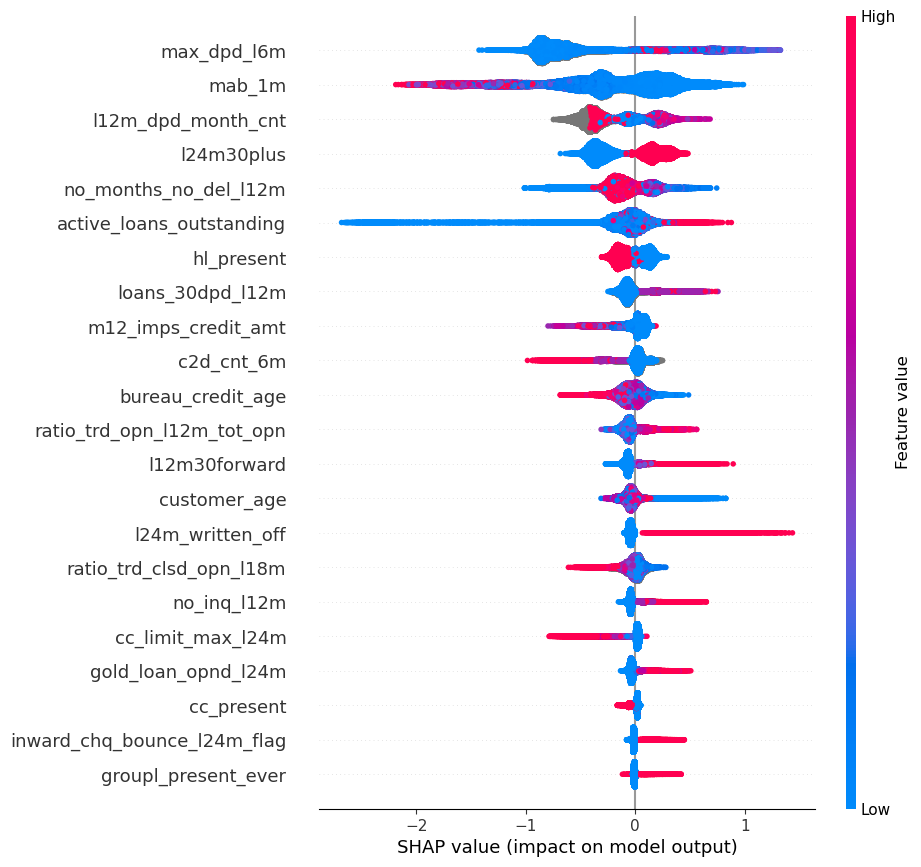

In [37]:
shap.plots.beeswarm(shap_values,max_display=40)

In [38]:
y_pred=xgb_clf.predict(X_ts[model_fts])

In [39]:
# xgboost default feature importance varies fromm shapely as these are all approximations

feature_importance_xg=pd.DataFrame({'feature':model_fts, 'importance':xgb_clf.feature_importances_})
feature_importance_xg=feature_importance_xg.sort_values(by='importance', ascending=False).reset_index(drop=True)
display(feature_importance_xg)

feature  importance
0                   max_dpd_l6m    0.200926
1                    l24m30plus    0.111780
2            l12m_dpd_month_cnt    0.075483
3              l24m_written_off    0.062257
4              loans_30dpd_l12m    0.059454
5                    hl_present    0.049465
6                        mab_1m    0.049246
7         no_months_no_del_l12m    0.044524
8                 l12m30forward    0.036405
9                    c2d_cnt_6m    0.035246
10          groupl_present_ever    0.028854
11     active_loans_outstanding    0.028467
12                 customer_age    0.025922
13          gold_loan_opnd_l24m    0.024795
14          m12_imps_credit_amt    0.024036
15   ratio_trd_opn_l12m_tot_opn    0.022146
16                  no_inq_l12m    0.022066
17            bureau_credit_age    0.021403
18            cc_limit_max_l24m    0.021160
19      ratio_trd_clsd_opn_l18m    0.019094
20                   cc_present    0.018693
21  inward_chq_bounce_l24m_flag    0.018575

In [40]:
# feature_importance_xg.to_csv('importance_xgb_Bscore_PK_v5.csv')

In [37]:
# ks function for deciling, ks etc..


def ks_fn(data, target, prob,cuts):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10,duplicates='drop')
    # print(data['bucket'].value_counts())
    grouped = data.groupby('bucket', as_index=False)
    # print()
    
    
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events'] = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
    kstable['event_rate'] =(kstable['events']/(kstable['events']+kstable['nonevents'])).apply('{0:.2%}'.format)
    kstable['event_capture_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_capture_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate'] = (kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3) * 100
    
    # Formatting
    kstable['cum_eventrate'] = kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate'] = kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    # print(kstable)
    
    kstable.index = range(1,data['bucket'].nunique()+1)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 20)
    
    # print(kstable)
    
    # Display KS
    print(Fore.RED + "KS is " + str(max(kstable['KS'])) + "%" + " at decile " + str((kstable.index[kstable['KS'] == max(kstable['KS'])][0])))
    
    return kstable


In [42]:
predprob_xg =xgb_clf.predict_proba(X_t[model_fts])[:,1]

X_t['DV']=Y_train
X_t['Prediction']=predprob_xg.tolist()

In [43]:
# from here its all performance metric including OOT


predprob_xg =xgb_clf.predict_proba(X_ts[model_fts])[:,1]

X_ts['DV']=Y_test
X_ts['Prediction']=predprob_xg.tolist()

In [44]:
KS_Table_train =ks_fn(X_t,'DV' ,'Prediction',10).sort_index(ascending = True)
display(KS_Table_train)

KS is 62.6% at decile 3


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
1       0.820329  0.969168    1864       8203     18.52%             52.17%   
2       0.687687  0.820320     904       9162      8.98%             25.30%   
3       0.521079  0.687660     461       9605      4.58%             12.90%   
4       0.377139  0.521065     187       9880      1.86%              5.23%   
5       0.268080  0.377115      83       9984      0.82%              2.32%   
6       0.187538  0.268042      44      10022      0.44%              1.23%   
7       0.127773  0.187538      19      10048      0.19%              0.53%   
8       0.078463  0.127768       7      10059      0.07%              0.20%   
9       0.039639  0.078459       4      10063      0.04%              0.11%   
10      0.002873  0.039635       0      10067      0.00%              0.00%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
1                      8.45%        52.17%            8.45%  43.7  
2                      9.44%        77.47%           17.88%  59.6  
3                      9.89%        90.37%           27.78%  62.6  
4                     10.18%        95.61%           37.95%  57.7  
5                     10.28%        97.93%           48.24%  49.7  
6                     10.32%        99.16%           58.56%  40.6  
7                     10.35%        99.69%           68.91%  30.8  
8                     10.36%        99.89%           79.27%  20.6  
9                     10.36%       100.00%           89.63%  10.4  
10                    10.37%       100.00%          100.00%   0.0

In [47]:
# KS_Table_test =KS(X_ts, 'Prediction','DV').sort_index(ascending = False)
KS_Table_test =ks_fn(X_ts,'DV' ,'Prediction',10).sort_index(ascending = True)
display(KS_Table_test)
# display(KS_Table_test)

KS is 55.400000000000006% at decile 3


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
1       0.820256  0.965214     677       3638     15.69%             45.10%   
2       0.689587  0.820241     366       3948      8.48%             24.38%   
3       0.523381  0.689581     210       4104      4.87%             13.99%   
4       0.376895  0.523358     111       4203      2.57%              7.40%   
5       0.265326  0.376835      62       4252      1.44%              4.13%   
6       0.186494  0.265316      33       4282      0.76%              2.20%   
7       0.125349  0.186481      23       4291      0.53%              1.53%   
8       0.078303  0.125321      10       4304      0.23%              0.67%   
9       0.039120  0.078297       6       4308      0.14%              0.40%   
10      0.002911  0.039114       3       4312      0.07%              0.20%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
1                      8.74%        45.10%            8.74%  36.4  
2                      9.48%        69.49%           18.22%  51.3  
3                      9.86%        83.48%           28.07%  55.4  
4                     10.09%        90.87%           38.17%  52.7  
5                     10.21%        95.00%           48.38%  46.6  
6                     10.28%        97.20%           58.66%  38.5  
7                     10.30%        98.73%           68.96%  29.8  
8                     10.34%        99.40%           79.30%  20.1  
9                     10.35%        99.80%           89.65%  10.2  
10                    10.35%       100.00%          100.00%   0.0

In [48]:
threshold=0.529396
X_t['Y_Pred_New']=np.where(X_t['Prediction']>threshold,1,0)

In [49]:
# threshold=0.493359
X_ts['Y_Pred_New']=np.where(X_ts['Prediction']>threshold,1,0)

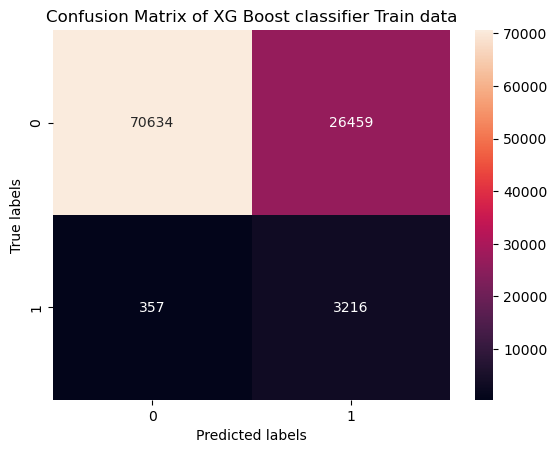

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt


ax=plt.subplot()
sns.heatmap(confusion_matrix(Y_train, X_t['Y_Pred_New']), annot=True, ax=ax, fmt='g')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of XG Boost classifier Train data')
ax.xaxis.set_ticklabels(['0','1']); ax.yaxis.set_ticklabels(['0','1']);

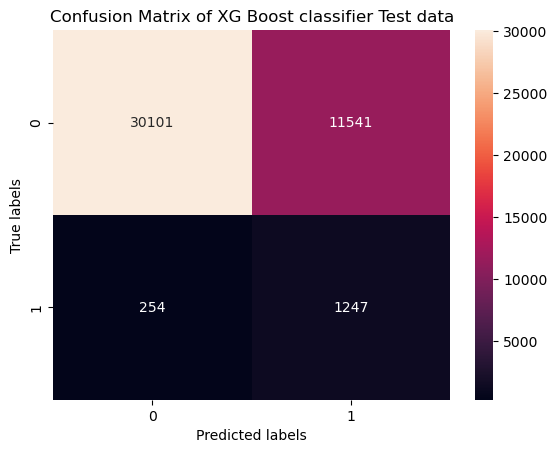

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt


ax=plt.subplot()
sns.heatmap(confusion_matrix(Y_test, X_ts['Y_Pred_New']), annot=True, ax=ax, fmt='g')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of XG Boost classifier Test data')
ax.xaxis.set_ticklabels(['0','1']); ax.yaxis.set_ticklabels(['0','1']);

In [52]:
FPR, TPR,_=roc_curve(Y_train, X_t['Y_Pred_New'])

AUC_Train=auc(FPR, TPR)

print('Train AUC :', round(AUC_Train,4))

Train AUC : 0.8138


In [53]:
FPR, TPR,_=roc_curve(Y_test, X_ts['Y_Pred_New'])

AUC_Test=auc(FPR, TPR)

print('Test AUC :', round(AUC_Test,4))

Test AUC : 0.7768


In [60]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy Score in Train:', round((accuracy_score(Y_train, X_t['Y_Pred_New'])),2))
print(classification_report(Y_train, X_t['Y_Pred_New']))

KeyError: 'Y_Pred_New'

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy Score in Test:', round((accuracy_score(Y_test, X_ts['Y_Pred_New'])),2))
print(classification_report(Y_test, X_ts['Y_Pred_New']))

KeyError: 'Y_Pred_New'

In [ ]:
# import joblib
# joblib.dump(xgb_clf,'XGB_BS_Final.pkl')

In [49]:
df_oot.shape

(168466, 405)

In [50]:
df_oot.head()

cust_id     snap_dt  bad  dev  l24m90plus  l24m60plus  l24m30plus  \
1  076120993  2023-11-30    0    0         1.0         1.0         1.0   
2  182062248  2023-11-30    0    0         1.0         1.0         1.0   
4  705074916  2023-10-31    0    0         1.0         1.0         1.0   
5  005012992  2023-11-30    0    0         0.0         0.0         0.0   
8  426110767  2023-11-30    0    0         0.0         1.0         1.0   

   l12m90plus  l12m60plus  l12m30plus  ...  c2d_amt_12m  c2d_cnt_12m  \
1         1.0         1.0         1.0  ...          NaN          NaN   
2         1.0         1.0         1.0  ...          NaN          NaN   
4         1.0         1.0         1.0  ...       0.7173          1.0   
5         0.0         0.0         0.0  ...       1.0132          0.0   
8         0.0         1.0         1.0  ...          NaN          NaN   

           exposure  retail_flag  msme_loan  no_months_no_del_l12m  bad_early  \
1              None            0          1                      0        0.0   
2              None            0          1                      0        0.0   
4  2822383.00000000            1          0                      0        1.0   
5   162692.00000000            0          1                     11        0.0   
8   253959.63000000            1          0                      2        0.0   

   inward_chq_bounce_ever  Pred_Score  Y_Pred_New  
1                       0    0.146611           0  
2                       0    0.199557           0  
4                       1    0.270706           0  
5                       0    0.630485           1  
8                       0    0.812347           1  

[5 rows x 405 columns]

In [51]:
df_oot['bad_early'].value_counts()

bad_early
0.0    149143
1.0     19323
Name: count, dtype: int64

In [52]:

# with open('xgb_9jul_bm.pkl', 'wb') as f:
#     pickle.dump(xgb_clf, f)


with open('xgb_9jul_bm.pkl', 'rb') as f:
    # Load the pickled dictionary
    xgb_clf = pickle.load(f)

with open('numeric_cols_bm.pkl', 'rb') as f:
    # Load the pickled dictionary
    numeric_cols = pickle.load(f)
    
with open('cols_bool_bm.pkl', 'rb') as f:
    # Load the pickled dictionary
    cols_bool = pickle.load(f)

with open('percentiles_dict_bm.pkl', 'rb') as f:
    # Load the pickled dictionary
    percentiles_dict_bm = pickle.load(f)

In [53]:
for col in numeric_cols:
    if col not in cols_bool:
        if col in df_oot.columns.to_list():
            df_oot[col][df_oot[col] <= percentiles_dict_bm.get(col)[0]] = percentiles_dict_bm.get(col)[0]
            df_oot[col][df_oot[col] >= percentiles_dict_bm.get(col)[1]] = percentiles_dict_bm.get(col)[1]

In [63]:
df_oot["Pred_Score"]=xgb_clf.predict_proba(df_oot[model_fts])[:,1]
threshold=0.529396
df_oot['Y_Pred_New']=np.where(df_oot['Pred_Score']>threshold,1,0)

In [67]:
# oot_months=df_oot['snap_dt'].unique()
# oot_months.sort()
# print(oot_months)
# for i in oot_months:
    # print(f'event rate is : {(df_oot[df_oot.good==1].shape[0])/(df_oot.shape[0])} ')
    # print(f'KS for OOT month : {i}')

Oot_t=df_oot.copy()
print('Accuracy Score in Train:', round((accuracy_score(Oot_t['bad'], Oot_t['Y_Pred_New'])),2))
print(classification_report(Oot_t['bad'], Oot_t['Y_Pred_New']))
FPR, TPR,_=roc_curve(Oot_t['bad'], Oot_t['Pred_Score'])
print(confusion_matrix(Oot_t['bad'], Oot_t['Y_Pred_New']))
AUC_cut=auc(FPR, TPR)
print(f'AUC for OOT month is : {AUC_cut} ')
print(f'event rate is : {(Oot_t[Oot_t.bad==1].shape[0])/(Oot_t.shape[0])} ')
Oot_t=Oot_t[model_fts+["Pred_Score",'bad']]
KS_Table_oot =ks_fn(Oot_t,'bad' ,'Pred_Score',10).sort_index(ascending = False)
display(KS_Table_oot)


Accuracy Score in Train: 0.73
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    163850
           1       0.08      0.80      0.14      4616

    accuracy                           0.73    168466
   macro avg       0.53      0.76      0.49    168466
weighted avg       0.97      0.73      0.82    168466

[[119588  44262]
 [   942   3674]]
AUC for OOT month is : 0.8237568766133797 
event rate is : 0.027400187574940938 
KS is 53.2% at decile 3


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.002005  0.037325      19      16828      0.11%              0.41%   
9       0.037326  0.073734      37      16810      0.22%              0.80%   
8       0.073736  0.120175      65      16781      0.39%              1.41%   
7       0.120176  0.177782      77      16770      0.46%              1.67%   
6       0.177782  0.255253     118      16728      0.70%              2.56%   
5       0.255254  0.365250     203      16644      1.20%              4.40%   
4       0.365265  0.504310     326      16520      1.94%              7.06%   
3       0.504335  0.670863     723      16124      4.29%             15.66%   
2       0.670865  0.812622    1195      15651      7.09%             25.89%   
1       0.812630  0.968995    1853      14994     11.00%             40.14%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    10.27%       100.00%          100.00%   0.0  
9                     10.26%        99.59%           89.73%   9.9  
8                     10.24%        98.79%           79.47%  19.3  
7                     10.23%        97.38%           69.23%  28.2  
6                     10.21%        95.71%           58.99%  36.7  
5                     10.16%        93.15%           48.78%  44.4  
4                     10.08%        88.76%           38.63%  50.1  
3                      9.84%        81.69%           28.54%  53.2  
2                      9.55%        66.03%           18.70%  47.3  
1                      9.15%        40.14%            9.15%  31.0

In [62]:
# KS_Table_OOT =decile_report(df_oot, 'Pred_Score','good').sort_index(ascending = False)
# display(KS_Table_OOT)
oot_months=df_oot['snap_dt'].unique()
oot_months.sort()
# print(oot_months)
for i in oot_months:
    # print(f'event rate is : {(df_oot[df_oot.good==1].shape[0])/(df_oot.shape[0])} ')
    print(f'KS for OOT month : {i}')

    Oot_t=df_oot[df_oot['snap_dt']==i]
    # print('Accuracy Score in Train:', round((accuracy_score(Y_train, X_t['Y_Pred_New'])),2))
    print(classification_report(Oot_t['bad'], Oot_t['Y_Pred_New']))
    FPR, TPR,_=roc_curve(Oot_t['bad'], Oot_t['Pred_Score'])
    AUC_cut=auc(FPR, TPR)
    print(f'AUC for OOT month {i} is : {AUC_cut} ')
    print(f'event rate is : {(Oot_t[Oot_t.bad==1].shape[0])/(Oot_t.shape[0])} ')
    Oot_t=Oot_t[model_fts+["Pred_Score",'bad']]
    KS_Table_oot =ks_fn(Oot_t,'bad' ,'Pred_Score',10).sort_index(ascending = False)
    display(KS_Table_oot)

KS for OOT month : 2023-10-31
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     81304
           1       0.08      0.80      0.14      2319

    accuracy                           0.73     83623
   macro avg       0.53      0.76      0.49     83623
weighted avg       0.97      0.73      0.82     83623

AUC for OOT month 2023-10-31 is : 0.8223048213431119 
event rate is : 0.027731604941224303 
KS is 52.900000000000006% at decile 3


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.002005  0.038427      10       8353      0.12%              0.43%   
9       0.038432  0.075081      22       8341      0.26%              0.95%   
8       0.075087  0.122148      30       8331      0.36%              1.29%   
7       0.122149  0.180193      38       8324      0.45%              1.64%   
6       0.180198  0.259053      61       8302      0.73%              2.63%   
5       0.259092  0.370873     101       8262      1.21%              4.36%   
4       0.370876  0.510195     168       8193      2.01%              7.24%   
3       0.510213  0.675585     378       7984      4.52%             16.30%   
2       0.675586  0.814224     564       7798      6.74%             24.32%   
1       0.814237  0.968995     947       7416     11.32%             40.84%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    10.27%       100.00%          100.00%  -0.0  
9                     10.26%        99.57%           89.73%   9.8  
8                     10.25%        98.62%           79.47%  19.2  
7                     10.24%        97.33%           69.22%  28.1  
6                     10.21%        95.69%           58.98%  36.7  
5                     10.16%        93.06%           48.77%  44.3  
4                     10.08%        88.70%           38.61%  50.1  
3                      9.82%        81.46%           28.53%  52.9  
2                      9.59%        65.16%           18.71%  46.4  
1                      9.12%        40.84%            9.12%  31.7

KS for OOT month : 2023-11-30
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     82546
           1       0.08      0.79      0.14      2297

    accuracy                           0.74     84843
   macro avg       0.53      0.76      0.49     84843
weighted avg       0.97      0.74      0.82     84843

AUC for OOT month 2023-11-30 is : 0.8251891392734455 
event rate is : 0.027073535824994402 
KS is 53.300000000000004% at decile 3


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.002632  0.036319       9       8476      0.11%              0.39%   
9       0.036319  0.072527      17       8467      0.20%              0.74%   
8       0.072530  0.118094      30       8454      0.35%              1.31%   
7       0.118102  0.175435      42       8442      0.50%              1.83%   
6       0.175437  0.252236      57       8428      0.67%              2.48%   
5       0.252239  0.359644      99       8385      1.17%              4.31%   
4       0.359702  0.497936     163       8321      1.92%              7.10%   
3       0.497967  0.666013     343       8141      4.04%             14.93%   
2       0.666020  0.810990     625       7859      7.37%             27.21%   
1       0.811026  0.964449     912       7573     10.75%             39.70%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    10.27%       100.00%          100.00%   0.0  
9                     10.26%        99.61%           89.73%   9.9  
8                     10.24%        98.87%           79.47%  19.4  
7                     10.23%        97.56%           69.23%  28.3  
6                     10.21%        95.73%           59.01%  36.7  
5                     10.16%        93.25%           48.80%  44.5  
4                     10.08%        88.94%           38.64%  50.3  
3                      9.86%        81.85%           28.56%  53.3  
2                      9.52%        66.91%           18.70%  48.2  
1                      9.17%        39.70%            9.17%  30.5

In [63]:
# KS_Table_OOT =decile_report(df_oot, 'Pred_Score','good').sort_index(ascending = False)
# display(KS_Table_OOT)
oot_months=df_oot['snap_dt'].unique()
oot_months.sort()
# print(oot_months)
for i in oot_months:
    # print(f'event rate is : {(df_oot[df_oot.good==1].shape[0])/(df_oot.shape[0])} ')
    print(f'KS for OOT month : {i}')

    Oot_t=df_oot[df_oot['snap_dt']==i]
    # print('Accuracy Score in Train:', round((accuracy_score(Y_train, X_t['Y_Pred_New'])),2))
    print(classification_report(Oot_t['bad'], Oot_t['Y_Pred_New']))
    FPR, TPR,_=roc_curve(Oot_t['bad'], Oot_t['Pred_Score'])
    AUC_cut=auc(FPR, TPR)
    print(f'AUC for OOT month {i} is : {AUC_cut} ')
    print(f'event rate is : {(Oot_t[Oot_t.bad==1].shape[0])/(Oot_t.shape[0])} ')
    Oot_t=Oot_t[model_fts+["Pred_Score",'bad']]
    KS_Table_oot =ks_fn(Oot_t,'bad' ,'Pred_Score',10).sort_index(ascending = False)
    display(KS_Table_oot)

KS for OOT month : 2023-10-31
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     81304
           1       0.08      0.80      0.14      2319

    accuracy                           0.73     83623
   macro avg       0.53      0.76      0.49     83623
weighted avg       0.97      0.73      0.82     83623

AUC for OOT month 2023-10-31 is : 0.8223048213431119 
event rate is : 0.027731604941224303 
KS is 52.900000000000006% at decile 3


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.002005  0.038427      10       8353      0.12%              0.43%   
9       0.038432  0.075081      22       8341      0.26%              0.95%   
8       0.075087  0.122148      30       8331      0.36%              1.29%   
7       0.122149  0.180193      38       8324      0.45%              1.64%   
6       0.180198  0.259053      61       8302      0.73%              2.63%   
5       0.259092  0.370873     101       8262      1.21%              4.36%   
4       0.370876  0.510195     168       8193      2.01%              7.24%   
3       0.510213  0.675585     378       7984      4.52%             16.30%   
2       0.675586  0.814224     564       7798      6.74%             24.32%   
1       0.814237  0.968995     947       7416     11.32%             40.84%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    10.27%       100.00%          100.00%  -0.0  
9                     10.26%        99.57%           89.73%   9.8  
8                     10.25%        98.62%           79.47%  19.2  
7                     10.24%        97.33%           69.22%  28.1  
6                     10.21%        95.69%           58.98%  36.7  
5                     10.16%        93.06%           48.77%  44.3  
4                     10.08%        88.70%           38.61%  50.1  
3                      9.82%        81.46%           28.53%  52.9  
2                      9.59%        65.16%           18.71%  46.4  
1                      9.12%        40.84%            9.12%  31.7

KS for OOT month : 2023-11-30
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     82546
           1       0.08      0.79      0.14      2297

    accuracy                           0.74     84843
   macro avg       0.53      0.76      0.49     84843
weighted avg       0.97      0.74      0.82     84843

AUC for OOT month 2023-11-30 is : 0.8251891392734455 
event rate is : 0.027073535824994402 
KS is 53.300000000000004% at decile 3


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.002632  0.036319       9       8476      0.11%              0.39%   
9       0.036319  0.072527      17       8467      0.20%              0.74%   
8       0.072530  0.118094      30       8454      0.35%              1.31%   
7       0.118102  0.175435      42       8442      0.50%              1.83%   
6       0.175437  0.252236      57       8428      0.67%              2.48%   
5       0.252239  0.359644      99       8385      1.17%              4.31%   
4       0.359702  0.497936     163       8321      1.92%              7.10%   
3       0.497967  0.666013     343       8141      4.04%             14.93%   
2       0.666020  0.810990     625       7859      7.37%             27.21%   
1       0.811026  0.964449     912       7573     10.75%             39.70%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    10.27%       100.00%          100.00%   0.0  
9                     10.26%        99.61%           89.73%   9.9  
8                     10.24%        98.87%           79.47%  19.4  
7                     10.23%        97.56%           69.23%  28.3  
6                     10.21%        95.73%           59.01%  36.7  
5                     10.16%        93.25%           48.80%  44.5  
4                     10.08%        88.94%           38.64%  50.3  
3                      9.86%        81.85%           28.56%  53.3  
2                      9.52%        66.91%           18.70%  48.2  
1                      9.17%        39.70%            9.17%  30.5

In [65]:
df_oot['exposure']=df_oot['exposure'].astype('float')
df_oot['exposure_bucket'] = pd.qcut(df_oot['exposure'], 4,duplicates='drop')
# df_oot['exposure_bucket'].value_counts()


In [66]:
oot_cat=df_oot['exposure_bucket'].unique()
# oot_cat.sort()
# stress_cat_day0
# print(oot_cat)
for i in oot_cat:
    if i is not np.nan:
        print(f'KS for OOT bucket : {i}')
        Oot_t=df_oot[df_oot['exposure_bucket']==i]
        print(classification_report(Oot_t['bad'], Oot_t['Y_Pred_New']))
        Oot_t=Oot_t[model_fts+["Pred_Score",'bad']]
        FPR, TPR,_=roc_curve(Oot_t['bad'], Oot_t['Pred_Score'])
        AUC_cut=auc(FPR, TPR)
        print(f'AUC for OOT month {i} is : {AUC_cut} ')
        print(f'event rate is : {(Oot_t[Oot_t.bad==1].shape[0])/(Oot_t.shape[0])} ')
        KS_Table_oot =ks_fn(Oot_t,'bad' ,'Pred_Score',10).sort_index(ascending = False)
        display(KS_Table_oot)


KS for OOT bucket : (1935738.39, 74854146.0]
              precision    recall  f1-score   support

           0       0.99      0.72      0.83     38923
           1       0.07      0.79      0.13      1014

    accuracy                           0.72     39937
   macro avg       0.53      0.76      0.48     39937
weighted avg       0.97      0.72      0.82     39937

AUC for OOT month (1935738.39, 74854146.0] is : 0.8142554097476933 
event rate is : 0.025389989233042042 
KS is 52.300000000000004% at decile 3


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.002005  0.030220       7       3988      0.18%              0.69%   
9       0.030223  0.056907      11       3982      0.28%              1.08%   
8       0.056907  0.094100      15       3978      0.38%              1.48%   
7       0.094106  0.145805      17       3977      0.43%              1.68%   
6       0.145864  0.224747      26       3968      0.65%              2.56%   
5       0.224765  0.352618      53       3941      1.33%              5.23%   
4       0.352625  0.515399      64       3929      1.60%              6.31%   
3       0.515492  0.697278     152       3841      3.81%             14.99%   
2       0.697323  0.826387     285       3709      7.14%             28.11%   
1       0.826425  0.968995     384       3610      9.61%             37.87%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    10.25%       100.00%          100.00%  -0.0  
9                     10.23%        99.31%           89.75%   9.6  
8                     10.22%        98.22%           79.52%  18.7  
7                     10.22%        96.75%           69.30%  27.4  
6                     10.19%        95.07%           59.09%  36.0  
5                     10.13%        92.50%           48.89%  43.6  
4                     10.09%        87.28%           38.77%  48.5  
3                      9.87%        80.97%           28.67%  52.3  
2                      9.53%        65.98%           18.80%  47.2  
1                      9.27%        37.87%            9.27%  28.6

KS for OOT bucket : (-0.001, 237342.0]
              precision    recall  f1-score   support

           0       0.99      0.66      0.79     38312
           1       0.09      0.77      0.16      1626

    accuracy                           0.67     39938
   macro avg       0.54      0.72      0.48     39938
weighted avg       0.95      0.67      0.77     39938

AUC for OOT month (-0.001, 237342.0] is : 0.7740246810225464 
event rate is : 0.04071310531323551 
KS is 43.9% at decile 4


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.004346  0.066335       6       3988      0.15%              0.37%   
9       0.066369  0.131530      31       3963      0.78%              1.91%   
8       0.131533  0.199978      32       3962      0.80%              1.97%   
7       0.199984  0.282444      57       3936      1.43%              3.51%   
6       0.282450  0.374017      67       3927      1.68%              4.12%   
5       0.374031  0.476529      98       3896      2.45%              6.03%   
4       0.476534  0.593973     176       3817      4.41%             10.82%   
3       0.593979  0.714579     304       3690      7.61%             18.70%   
2       0.714601  0.822017     361       3633      9.04%             22.20%   
1       0.822018  0.948366     494       3500     12.37%             30.38%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    10.41%       100.00%          100.00%  -0.0  
9                     10.34%        99.63%           89.59%  10.0  
8                     10.34%        97.72%           79.25%  18.5  
7                     10.27%        95.76%           68.91%  26.9  
6                     10.25%        92.25%           58.63%  33.6  
5                     10.17%        88.13%           48.38%  39.7  
4                      9.96%        82.10%           38.21%  43.9  
3                      9.63%        71.28%           28.25%  43.0  
2                      9.48%        52.58%           18.62%  34.0  
1                      9.14%        30.38%            9.14%  21.2

KS for OOT bucket : (237342.0, 800311.0]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     38799
           1       0.08      0.83      0.15      1138

    accuracy                           0.73     39937
   macro avg       0.54      0.78      0.49     39937
weighted avg       0.97      0.73      0.82     39937

AUC for OOT month (237342.0, 800311.0] is : 0.8403886897416549 
event rate is : 0.0284948794351103 
KS is 55.00000000000001% at decile 3


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.002507  0.038558       2       3992      0.05%              0.18%   
9       0.038559  0.077044       7       3987      0.18%              0.62%   
8       0.077062  0.124772      12       3981      0.30%              1.05%   
7       0.124845  0.184564      13       3981      0.33%              1.14%   
6       0.184585  0.260220      30       3964      0.75%              2.64%   
5       0.260222  0.366599      39       3954      0.98%              3.43%   
4       0.366694  0.511201      86       3908      2.15%              7.56%   
3       0.511261  0.686044     156       3837      3.91%             13.71%   
2       0.686088  0.822868     297       3697      7.44%             26.10%   
1       0.822883  0.947272     496       3498     12.42%             43.59%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    10.29%       100.00%          100.00%   0.0  
9                     10.28%        99.82%           89.71%  10.1  
8                     10.26%        99.21%           79.44%  19.8  
7                     10.26%        98.15%           69.17%  29.0  
6                     10.22%        97.01%           58.91%  38.1  
5                     10.19%        94.38%           48.70%  45.7  
4                     10.07%        90.95%           38.51%  52.4  
3                      9.89%        83.39%           28.43%  55.0  
2                      9.53%        69.68%           18.54%  51.1  
1                      9.02%        43.59%            9.02%  34.6

KS for OOT bucket : (800311.0, 1935738.39]
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     39099
           1       0.07      0.80      0.12       838

    accuracy                           0.76     39937
   macro avg       0.53      0.78      0.49     39937
weighted avg       0.97      0.76      0.85     39937

AUC for OOT month (800311.0, 1935738.39] is : 0.8434743492148715 
event rate is : 0.02098304830107419 
KS is 56.49999999999999% at decile 3


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.003324  0.030657       5       3990      0.13%              0.60%   
9       0.030659  0.058979       4       3989      0.10%              0.48%   
8       0.058985  0.094159       8       3985      0.20%              0.95%   
7       0.094177  0.138574       8       3986      0.20%              0.95%   
6       0.138580  0.201153      17       3977      0.43%              2.03%   
5       0.201161  0.301071      38       3955      0.95%              4.53%   
4       0.301081  0.437601      43       3951      1.08%              5.13%   
3       0.437629  0.622912     115       3878      2.88%             13.72%   
2       0.622980  0.793624     213       3781      5.33%             25.42%   
1       0.793677  0.955425     387       3607      9.69%             46.18%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    10.20%       100.00%          100.00%  -0.0  
9                     10.20%        99.40%           89.80%   9.6  
8                     10.19%        98.93%           79.59%  19.3  
7                     10.19%        97.97%           69.40%  28.6  
6                     10.17%        97.02%           59.21%  37.8  
5                     10.12%        94.99%           49.03%  46.0  
4                     10.11%        90.45%           38.92%  51.5  
3                      9.92%        85.32%           28.81%  56.5  
2                      9.67%        71.60%           18.90%  52.7  
1                      9.23%        46.18%            9.23%  37.0

In [ ]:
# df_oot.columns

In [67]:
# oot_cat=df_oot['retail_flag'].unique()
# oot_cat.sort()
# stress_cat_day0
# print(oot_cat)

print('KS for OOT bucket : retail')
Oot_t=df_oot[df_oot['retail_flag']==1]
print(classification_report(Oot_t['bad'], Oot_t['Y_Pred_New']))
Oot_t=Oot_t[model_fts+["Pred_Score",'bad']]
FPR, TPR,_=roc_curve(Oot_t['bad'], Oot_t['Pred_Score'])
AUC_cut=auc(FPR, TPR)
print(f'AUC for OOT retail is : {AUC_cut} ')
print(f'event rate is : {(Oot_t[Oot_t.bad==1].shape[0])/(Oot_t.shape[0])} ')
KS_Table_oot =ks_fn(Oot_t,'bad' ,'Pred_Score',10).sort_index(ascending = False)
display(KS_Table_oot)

print('KS for OOT bucket : msme')
Oot_t=df_oot[df_oot['msme_loan']==1]
print(classification_report(Oot_t['bad'], Oot_t['Y_Pred_New']))
Oot_t=Oot_t[model_fts+["Pred_Score",'bad']]

FPR, TPR,_=roc_curve(Oot_t['bad'], Oot_t['Pred_Score'])
AUC_cut=auc(FPR, TPR)
print(f'AUC for OOT msme is : {AUC_cut} ')
print(f'event rate is : {(Oot_t[Oot_t.bad==1].shape[0])/(Oot_t.shape[0])} ')
KS_Table_oot =ks_fn(Oot_t,'bad' ,'Pred_Score',10).sort_index(ascending = False)
display(KS_Table_oot)


KS for OOT bucket : retail
              precision    recall  f1-score   support

           0       0.99      0.74      0.85    132871
           1       0.07      0.81      0.13      3339

    accuracy                           0.74    136210
   macro avg       0.53      0.77      0.49    136210
weighted avg       0.97      0.74      0.83    136210

AUC for OOT retail is : 0.8342734124647295 
event rate is : 0.0245136186770428 
KS is 55.2% at decile 3


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.002005  0.034350      13      13609      0.10%              0.39%   
9       0.034352  0.066834      29      13592      0.21%              0.87%   
8       0.066836  0.109323      35      13585      0.26%              1.05%   
7       0.109323  0.163400      40      13581      0.29%              1.20%   
6       0.163402  0.239409      90      13531      0.66%              2.70%   
5       0.239411  0.346592     141      13480      1.04%              4.22%   
4       0.346595  0.484702     190      13432      1.39%              5.69%   
3       0.484707  0.661010     481      13139      3.53%             14.41%   
2       0.661010  0.811868     889      12732      6.53%             26.62%   
1       0.811875  0.968995    1431      12190     10.51%             42.86%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    10.24%       100.00%          100.00%  -0.0  
9                     10.23%        99.61%           89.76%   9.9  
8                     10.22%        98.74%           79.53%  19.2  
7                     10.22%        97.69%           69.30%  28.4  
6                     10.18%        96.50%           59.08%  37.4  
5                     10.15%        93.80%           48.90%  44.9  
4                     10.11%        89.58%           38.75%  50.8  
3                      9.89%        83.89%           28.65%  55.2  
2                      9.58%        69.48%           18.76%  50.7  
1                      9.17%        42.86%            9.17%  33.7

KS for OOT bucket : msme
              precision    recall  f1-score   support

           0       0.99      0.67      0.80     33600
           1       0.09      0.77      0.16      1350

    accuracy                           0.68     34950
   macro avg       0.54      0.72      0.48     34950
weighted avg       0.95      0.68      0.78     34950

AUC for OOT msme is : 0.7798652557319223 
event rate is : 0.03862660944206009 
KS is 44.9% at decile 4


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.004140  0.061759      10       3485      0.29%              0.74%   
9       0.061767  0.117087      26       3469      0.74%              1.93%   
8       0.117088  0.177918      29       3466      0.83%              2.15%   
7       0.177928  0.241799      22       3474      0.63%              1.63%   
6       0.241819  0.333475      50       3445      1.43%              3.70%   
5       0.333495  0.449338      90       3404      2.58%              6.67%   
4       0.449379  0.587137     154       3341      4.41%             11.41%   
3       0.587155  0.713684     241       3254      6.90%             17.85%   
2       0.713799  0.825402     299       3196      8.56%             22.15%   
1       0.825501  0.966904     429       3066     12.27%             31.78%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    10.37%       100.00%          100.00%  -0.0  
9                     10.32%        99.26%           89.63%   9.6  
8                     10.32%        97.33%           79.30%  18.0  
7                     10.34%        95.19%           68.99%  26.2  
6                     10.25%        93.56%           58.65%  34.9  
5                     10.13%        89.85%           48.40%  41.5  
4                      9.94%        83.19%           38.26%  44.9  
3                      9.68%        71.78%           28.32%  43.5  
2                      9.51%        53.93%           18.64%  35.3  
1                      9.12%        31.78%            9.12%  22.7

In [68]:
# KS_Table_OOT =decile_report(df_oot, 'Pred_Score','good').sort_index(ascending = False)
# display(KS_Table_OOT)
oot_months=df_oot['snap_dt'].unique()
oot_months.sort()
# print(oot_months)
for i in oot_months:
    # print(f'event rate is : {(df_oot[df_oot.good==1].shape[0])/(df_oot.shape[0])} ')
    print(f'KS for OOT month 1m0+: {i} ')

    Oot_t=df_oot[df_oot['snap_dt']==i]
    # print('Accuracy Score in Train:', round((accuracy_score(Y_train, X_t['Y_Pred_New'])),2))
    print(classification_report(Oot_t['bad_early'], Oot_t['Y_Pred_New']))
    FPR, TPR,_=roc_curve(Oot_t['bad_early'], Oot_t['Pred_Score'])
    AUC_cut=auc(FPR, TPR)
    print(f'AUC for OOT month {i} is : {AUC_cut} ')
    print(f'event rate is : {(Oot_t[Oot_t.bad==1].shape[0])/(Oot_t.shape[0])} ')
    Oot_t=Oot_t[model_fts+["Pred_Score",'bad_early']]
    KS_Table_oot =ks_fn(Oot_t,'bad_early' ,'Pred_Score',10).sort_index(ascending = False)
    display(KS_Table_oot)

KS for OOT month 1m0+: 2023-10-31 
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83     73757
         1.0       0.24      0.58      0.33      9866

    accuracy                           0.73     83623
   macro avg       0.58      0.66      0.58     83623
weighted avg       0.85      0.73      0.77     83623

AUC for OOT month 2023-10-31 is : 0.7308024928183297 
event rate is : 0.027731604941224303 
KS is 36.7% at decile 4


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.002005  0.038427   128.0     8235.0      1.53%              1.30%   
9       0.038432  0.075081   241.0     8122.0      2.88%              2.44%   
8       0.075087  0.122148   356.0     8005.0      4.26%              3.61%   
7       0.122149  0.180193   445.0     7917.0      5.32%              4.51%   
6       0.180198  0.259053   610.0     7753.0      7.29%              6.18%   
5       0.259092  0.370873   947.0     7416.0     11.32%              9.60%   
4       0.370876  0.510195  1281.0     7080.0     15.32%             12.98%   
3       0.510213  0.675585  1761.0     6601.0     21.06%             17.85%   
2       0.675586  0.814224  2030.0     6332.0     24.28%             20.58%   
1       0.814237  0.968995  2067.0     6296.0     24.72%             20.95%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    11.17%       100.00%          100.00%   0.0  
9                     11.01%        98.70%           88.83%   9.9  
8                     10.85%        96.26%           77.82%  18.4  
7                     10.73%        92.65%           66.97%  25.7  
6                     10.51%        88.14%           56.24%  31.9  
5                     10.05%        81.96%           45.72%  36.2  
4                      9.60%        72.36%           35.67%  36.7  
3                      8.95%        59.38%           26.07%  33.3  
2                      8.58%        41.53%           17.12%  24.4  
1                      8.54%        20.95%            8.54%  12.4

KS for OOT month 1m0+: 2023-11-30 
              precision    recall  f1-score   support

         0.0       0.93      0.76      0.84     75386
         1.0       0.23      0.58      0.33      9457

    accuracy                           0.74     84843
   macro avg       0.58      0.67      0.58     84843
weighted avg       0.86      0.74      0.78     84843

AUC for OOT month 2023-11-30 is : 0.7391435576874004 
event rate is : 0.027073535824994402 
KS is 38.3% at decile 4


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.002632  0.036319    90.0     8395.0      1.06%              0.95%   
9       0.036319  0.072527   193.0     8291.0      2.27%              2.04%   
8       0.072530  0.118094   329.0     8155.0      3.88%              3.48%   
7       0.118102  0.175435   444.0     8040.0      5.23%              4.69%   
6       0.175437  0.252236   529.0     7956.0      6.23%              5.59%   
5       0.252239  0.359644   870.0     7614.0     10.25%              9.20%   
4       0.359702  0.497936  1243.0     7241.0     14.65%             13.14%   
3       0.497967  0.666013  1706.0     6778.0     20.11%             18.04%   
2       0.666020  0.810990  2021.0     6463.0     23.82%             21.37%   
1       0.811026  0.964449  2032.0     6453.0     23.95%             21.49%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    11.14%       100.00%          100.00%  -0.0  
9                     11.00%        99.05%           88.86%  10.2  
8                     10.82%        97.01%           77.87%  19.1  
7                     10.67%        93.53%           67.05%  26.5  
6                     10.55%        88.83%           56.38%  32.5  
5                     10.10%        83.24%           45.83%  37.4  
4                      9.61%        74.04%           35.73%  38.3  
3                      8.99%        60.90%           26.12%  34.8  
2                      8.57%        42.86%           17.13%  25.7  
1                      8.56%        21.49%            8.56%  12.9

In [59]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import joblib
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [70]:
# FPR, TPR,_=roc_curve(data_1['bad'], data_1['Y_Pred_New'])

# AUC_Train=auc(FPR, TPR)

# print('Train AUC :', round(AUC_Train,4))

In [71]:
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report

# print('Accuracy Score in OOT:', round((accuracy_score(data_1['bad'], data_1['Y_Pred_New'])),2))
# print(classification_report(data_1['bad'], data_1['Y_Pred_New']))

In [72]:
# def lift_chart(X,actual_target,model):
#     avg_tgt = actual_target.sum()/len(actual_target)
#     df_data = X.copy()
#     X_data = df_data.copy()
#     df_data['Actual'] = actual_target
#     df_data['Predict']= model.predict(X_data)
#     y_Prob = pd.DataFrame(model.predict_proba(X_data))
#     df_data['Prob_1']=list(y_Prob[1])
#     df_data.sort_values(by=['Prob_1'],ascending=False,inplace=True)
#     df_data.reset_index(drop=True,inplace=True)
#     df_data['Decile']=pd.qcut(df_data.index,10,labels=False)
#     output_df = pd.DataFrame()
#     grouped = df_data.groupby('Decile',as_index=False)
#     output_df['Max_Scr']=grouped.max().Prob_1
#     output_df['Min_Scr']=grouped.min().Prob_1
#     output_df['Actual']=grouped.sum().Actual
#     output_df['Total']=grouped.count().Actual
#     output_df["Population_perc"] = (output_df["Total"]/len(actual_target))*100
#     output_df['Per_Events'] = (output_df['Actual']/output_df['Actual'].sum())*100
#     output_df['Gain_Percentage'] = output_df.Per_Events.cumsum()
#     output_df["Cumulative_Population"] = output_df.Population_perc.cumsum()
#     output_df["Lift"] = output_df["Gain_Percentage"]/output_df["Cumulative_Population"]
#     return output_df

In [73]:
# lift_oot =lift_chart(data_1[model_fts],data_1['bad'],xgb_clf)

In [74]:
# lift_oot.head(10)

In [75]:
# with open('xgb_9jul_bm.pkl', 'wb') as f:
#     pickle.dump(xgb_clf, f)


In [ ]:
# df_test_npa=pd.read_parquet('s3://576118004139-ap-south-1-kbl-datamart-l2/datamartl2/npa_forecasting/Roll_rates_history/roll_rates_hist_test.parquet')

In [ ]:
# df_test_npa.to_csv('test.csv')